# ETL (Extract Transform Load) Hispasonic

<br>



In my case, the data comes from the daily sampling I do with a raspberry pi 1.

I connect via ssh on the local network and download the folders containing the date I am interested in to the main computer with which I work

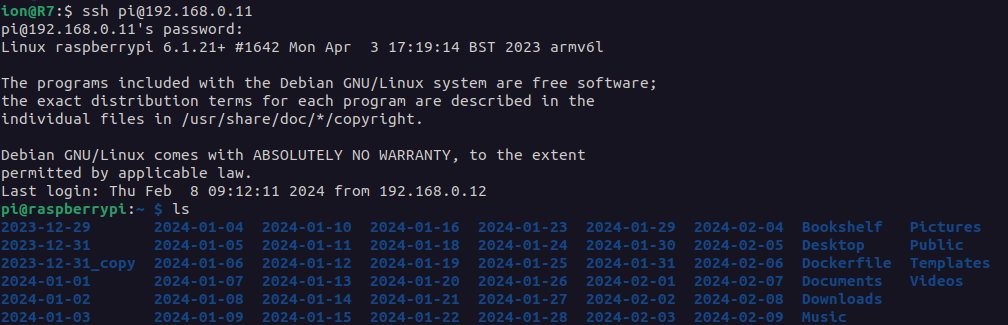

What I've done can be considered a form of ETL (Extraction, Transformation, and Loading). Here's how my steps relate to the components of ETL:

- **Extraction**: I extracted data from HTML files from different folders. This stage involves gathering data from various sources and bringing them to a centralized location for further processing.

- **Transformation**: After extracting the data, I performed several transformations on them. This includes creating a dictionary for ad name identification and analyzing various parts of the HTML, such as date, equipment, brand, and city. During this stage, I may have cleaned the data, removed duplicates, normalized values, and performed other operations to prepare the data for analysis.

- **Loading**: Finally, I created a dataset in CSV format. This stage involves loading the transformed data into a final destination, such as a database, data warehouse, or flat file, so that they are ready for analysis and further use.

<br>

After having been doing tests I have finally come to the conclusion that the daily sampling would finally give me a superior understanding of the buying and selling of articles on the web, however this also entails an intrinsic problem that is the repetition of information and therefore must be kept in mind to avoid firstly the duplication of data and secondly the analysis time of each one of HTML pages.

There is no intention to sell the information to anyone, neither the data, nor the brands, this is simply a personal exercise on the knowledge of the technologies and how far you can go with such irrelevant data at first glance.

### We load the necessary modules:

In [1]:
import os
import pandas as pd
import seaborn as sn
from bs4 import BeautifulSoup
from matplotlib import pyplot as plt
import datetime as dt

To extract the names of the manufacturers, we need to create a dictionary that contains not only the exact names, but also the possible variations and ways in which they appear in the ads. 

For example, let's consider the `Make Noise` brand. 

Although the full manufacturer's name is "Make Noise", commonly, when referring to a synthesizer of this brand, specifically the `0 Coast` model, it is often mentioned only the model, implying which brand we are referring to. 

<img src="https://www.makenoisemusic.com/thumbs/synthesizers/ohcoast/0-coast-sep20-1584x1056-q100.jpg" alt="drawing" width="400"/>

However, this model can be written by the person selling it in different ways, such as:



- `coast` 
- `0_coast` 
- `0Coast` 
- `0coast`


In [2]:
sintes = ['coast', '0_coast', '0Coast', '0coast', 'bohm','audibax','dsi','leslie','akemie','tiptop','prophet','mopho', 'falcon','teletype',
          'nord','malekko','teia','solton','young chang','erica','endorphin','ornament and crime','subharmonicon', 
          'studilogic fatar','bastl','disting','birkids','herzlich','syncussion','minifreak','x0xb0x','motif',
          'minibrute','wardrf','wardrf blofed','siel','cortex','000', '4ms', 'avp a-v-p_synth', 'acces', 'access', 
          'digitakt elektron','voix la-voix-du-luthier', 'luthier la-voix-du-luthier',  'oktatrak elektron',
          'analog elektron','heat elektron','rythm elektron','digitone elektron','keys elektron','cycles elektron',
          'samples elektron','acidlab', 'akai', 'mpc akai','alembic', 'alesis', 'allen allen_&_heath', 'analogaudio1',
          'analogue solutions', 'analogue systems', 'arp', 'arturia', 'asm ashun_soundmachines',  'atomo atomo_synth', 
          'damage audio_damage', 'audiophile audiophile_circuits', 'axoloty', 'balaguer', 'baloran', 'bastl bastl_instruments', 
          'befaco', 'behringer',  'beringer', 'bheringer', 'bitbox', 'black corporation', 'boss', 'bubblesound instruments', 
          'buchla', 'casio', 'charlie lab', 'charvel', 'chronograf', 'circuit abbey', 'clavia',  'club knobs', 'corsynth', 
          'cre8audio', 'crumar', 'custom made', 'cyclone', 'cyclone', 'dave jones', 'dave smith',  'dave smith instruments', 
          'deepmind', 'delptronics', 'delta music', 'denon dj', 'dexibell', 'dexibell', 'digitack', 'doepfer',  'dreadbox', 
          'dubreq', 'dynacord', 'e mu', 'e-mu', 'e-mu', 'e:m:c', 'elby designs', 'electribe', 'electronic music laboratories (eml)',
          'electrovoice', 'elektron', 'elka', 'emc', 'emu', 'endorphin.es', 'endorphines', 'ensoniq', 'eowave', 'epiphone',
          'erica synth', 'erica synths',  'ernie ball music man', 'esp ltd', 'eurorack', 'eventide', 'evh', 'evolver', 'exodus digital',
          'farfisa', 'fender', 'fishman', 'fodera', 'formanta',  'frap tool', 'frequency central', 'fretlight', 'friedman', 
          'future retro', 'futuresonus', 'gator', 'gemini', 'generalmusic', 'gibson', 'godin', 'gotharman',  'graph tech', 
          'gretsch', 'guild', 'hammond', 'hartmann', 'hexinverter', 'hinton instruments', 'hofner', 'hypersynth', 'ibanez', 'ik', 
          'instruo', 'iomega',  'isla', 'jackson', 'jaspers', 'john bowen synth design', 'jomox', 'kawai', 'kenton', 'ketron', 
          'kilpatrick audio', 'knobula',  'koma elektronik', 'komplete', 'korg', 'kramer', 'kurzweil', 'kurzweil', 'lakland', 'line 6', 
          'linn electronics', 'livid', 'logan electronics', 'm-audio',  'macbeth studio systems', 'make', 'malekko', 'manikin electronic', 
          'maschine', 'mellotron', 'mfb', 'micro modular', 'miditech',  'models', 'modor', 'modular', 'modulus', 'monome', 'moog', 'mpc', 
          'mpc', 'mutable instruments', 'mutant', 'native instruments', 'neutron', 'noise engineering',  'nord', 'nord electro', 
          'nord lead 2 rack', 'nord lead 3', 'nord lead 3', 'nord lead 4', 'nord micro modular', 'nord modular', 'nord rack', 'nord stage',  
          'nord wave', 'novation', 'numark', 'oberheim', 'octatrack', 'orthogonal devices', 'paratek', 'pearl', 'peavey', 'pioneer dj', 
          'pittsburgh', 'pittsburgh modular',  'polyend', 'polygraf', 'ppg (palm products gmbh)', 'prs', 'qu bit', 'qu-bit', 
          'qu-bit electronix', 'quasimidi', 'qubit', 'quiklok', 'radikal technologies',  'rhodes', 'rickenbacker', 'roland', 'roli', 
          'sanson', 'schecter', 'sensel', 'sequencial', 'sequential circuits', 'sequentix', 'shakmat', 'simmons', 'soma', 'sonicware', 
          'special waves', 'spector', 'spectral audio', 'sputnik', 'squarp instruments',  'squier', 'ssff', 'stanton', 'steinberger', 
          'sterling', 'strymon', 'studio electronics', 'synamodec', 'synthesis technology',  'synthrotek', 'synthstrom', 'synthstrom', 
          'synthtech','swissonic', 'tascam', 'taylor', 'technos', 'teenage', 'teenage engineering', 'tiptop', 'tiptop audio',  'traveler guitar', 
          'udo audio', 'uno synth ', 'vermona', 'vermona', 'virus', 'viscount', 'volca', 'vox', 'waldorf', 'warwick', 'washburn', 
          'waves grendel',  'wersi', 'wersi music', 'winter modular', 'wmd', 'wmd / ssf', 'wurlitzer', 'yamaha', 'yocto', 'zeppelin design labs', 
          'zoom','1010 music', '2hp', '4ms', 'acid rain technology',  'acl', 'addac system', 'after later audio', 'aion modular', 'ajh synth', 
          'cosmos soma', 'divina soma', 'enner soma', 'ether soma', 'flux soma', 'illuminator soma',  'lyra-8 soma', 'lyra8-fx soma', 
          'metaconformer soma', 'ornament-8 soma', 'pulsar-23 soma', 'qo soma', 'reflex soma', 'roat soma', 'terra soma', 'the pipe soma', 
          'alm busy circuits', 'alright devices', 'analogue solutions', 'bastl instruments', 'befaco', 'blackhole cases', 'blue lantern', 
          'boredbrain music',  'bubblesound', 'buchla', 'cosmotronic', 'cre8audio', 'divkid', 'dnipro modular', 'doepfer', 'dreadbox', 'e-rm',
          'LinnDrum','Linn Electronics', 'electrosmith', 'emblematic systems',  'empress effects', 'endorphin.es', 'eowave', 'erica synths', 
          'erogenous tones', 'eskatonic modular', 'eventide', 'five12', 'frap tools', 'future sound systems',  'gieskes', 'grayscale', 'hexinverter', 
          'industrial music electronics','voix du luthier', 'instruo', 'io instruments', 'jomox', 'joranalogue', 'klavis',  'koma elektronik', 
          'l-1', 'lmntl', 'low-gain electronics', 'lzx industries', 'make noise','eloquencer', 'malekko heavy industry', 'manhattan analog', 
          'meng qi',  'michigan synth works', 'modbap modular', 'moog', 'mordax', 'mosaic', 'mrseri', 'mutable instruments', 'nano modules', 
          'noise engineering',  'patching panda', 'percussa', 'pittsburgh modular', 'plankton electronics', 'poly effects', 'qu-bit electronix', 
          'random source', 'ritual electronics',  'rossum', 'schlappi engineering', 'shakmat modular', 'soundforce', 'soundmachines', 'squarp', 
          'steady state fate', 'strymon', 'studio electronics',  'supercritical', 'synthesis technology', 'system 80', 'tall dog electronics', 
          'tasty chips', 'tenderfoot electronics', 'tesseract modular', 'tiptop audio',  'trogotronic', 'tubbutec', 'u-he', 'verbos electronics', 
          'vermona', 'voicas', 'vpme.de', 'winter modular', 'wmd', 'worng electronics', 'xaoc devices',  'xor electronics', 'zlob modular',"ASM",
          "Elektron","Moog","Teenage Engineering","Korg","Novation","Modal Electronics", "Black Corporation","Roland","Arturia","Critter & Guitari",
          "Polyend","UDO","Waldorf","Nord","Yamaha","Vermona","Crumar","JMT Synth","Modor", "Studio Electronics","Trogotronic","Gieskes","Akai","Dreadbox",
          "Herbs and Stones","IK Multimedia","Tasty Chips","Buchla","Soundmachines", "Access","Grp","Analogue Solutions","The Division Department","Norand",
          "Jomox","Sonicware","Radikal Technologies","Playtime Engineering", "1010 Music","Fred's Lab","Kilpatrick Audio","Eowave","Electrosmith","Meng Qi",
          "Studiologic","Suzuki","Nonlinear Labs","Dato","Artiphon", "Malekko Heavy Industry","Kodamo","Hikari Instruments","Manikin Electronic","Second Sound",
          "Arturia","Squarp","Polyend","Novation","Akai", "Roger Linn Design","Conductive Labs","Native Instruments","Faderfox","Sensel","Roland","Keith McMillen",
          "Pioneer","E-RM","Expressive E","Korg", "M-Audio","Alesis","JouÃ©","Soundforce","Yamaha","Genki","Erica Synths","Make Noise","Doepfer","Elektron","Moog",
          "Teenage Engineering","1010 Music","Expert Sleepers","BASTL Instruments","Kenton","Circuit Happy","MOTU","MIDI Solutions","Solid State Logic", 
          "Nord","Malekko Heavy Industry","Koma Elektronik","Random Source","Eowave","Zoom","Crumar","Electro-Harmonix","Grp","Michigan Synth Works", 
          "Analogue Solutions","Knas","iConnectivity","Soundmachines","Eurodesk-Z","Presonus","Torso Electronics","IK Multimedia","ESI Audiotechnik", 
          "Low-Gain Electronics","Artiphon","Instruments of Things","Apogee","SND","Moffenzeef","CME","Embodme", "Tech 21","Snyderphonics","Tricks Magic Shop",
          "Strymon","Vermona","OTO Machines","Dreadbox","Chase Bliss Audio","Boss","GFI","Meris", "Eventide","SOMA Laboratory","Echo Fix","Fairfield Circuitry",
          "Universal Audio","Gamechanger Audio","EarthQuaker Devices","Death By Audio", "Sherman","Electro-Harmonix","Old Blood Noise Endeavors","Knas","Red Panda",
          "Malekko Heavy Industry","Kemper","DigiTech","JAM Pedals", "Erica Synths","Elektron","WMD","1010 Music","Roland","Korg","Poly Effects","Jomox",
          "Thermionic Culture","Warm Audio", "Zoom","Boredbrain Music","Meng Qi","Electrosmith","Benidub","BAE","Trogotronic","MIDI Solutions","Plankton Electronics",
          "Vongon", "ART","Hungry Robot","Walrus Audio","Enjoy Electronics","CIOKS","TK Audio","Source Audio","API","Voodoo Lab", "FMR Audio","JHS Pedals",
          "MOD Devices","Cooper FX","Finegear","Ezhi & Aka","Truetone","LastGasp Art Laboratories","Origin Effects", "Rainger FX","Line 6","PedalTrain","Dr. Scientist",
          "Elta Music","Keeley","Recovery","Glou-Glou","Retro Mechanical Labs","Electro-Faustus", "Animal Factory","Hologram","Caroline Guitar Company","MXR","Second Sound",
          "Xotic","Dunlop","Adventure Audio","ISP Technologies", "Industrialectric","Tech 21","Collision Devices","Orgeldream","Universal Audio","API","Solid State Logic",
          "Rupert Neve Designs","Shure","MOTU", "Warm Audio","Focusrite","Vermona","Focal","Neumann","Roland","Thermionic Culture","Arturia","Zoom","Presonus","Adam","ART",
          "Yamaha", "TASCAM","Furman","Antelope Audio","Dangerous Music","Pioneer","Echo Fix","Native Instruments","Eventide","Allen & Heath", "Meris","Sherman","dbx","BAE",
          "Maag Audio","Empirical Labs","Avantone Pro","iConnectivity","Mackie","Audient","beyerdynamic","TK Audio", "IK Multimedia","Black Lion Audio","RME","Keith McMillen",
          "Golden Age Project","Audio-Technica","Fredenstein","A-Designs","Rosson Audio", "Daking","Looptrotter","Rode","Prism Sound","Samson","Cranborne Audio","ESI Audiotechnik",
          "Elysia","HEDD","FMR Audio","Heritage Audio", "Avedis Audio","Sennheiser","Lindell Audio","Blue Microphones","Apogee","Recovery","M-Audio","Zeppelin Design Labs","KRK","AKG",
          "Cloud Microphones","Steinberg","Alesis","Dynaudio","Austrian Audio","Auralex","IsoAcoustics","Aston Microphones","Auratone","sE Electronics","SE Electronics", "Tech 21",
          "Lauten Audio","Cascade Microphones","Soundrise","Pioneer","Allen & Heath","Pro-Ject","PLAYdifferently","U-Turn Audio","Audio-Technica", "Thorens","Audioengine","Technics",
          "Rane","AKG","Music Hall","Native Instruments","Numark","Sennheiser","Jesse Dean Designs","Ortofon", "Rosson Audio","MWM","Gator","IK Multimedia","ART","Yamaha",
          "Ultimate Support","RME","Roland","KRK","Austrian Audio","Shure","Odyssey", "Teenage Engineering","Denon","Record Props","Presonus","Hosa","Hosa","Mogami ","Roland ",
          "Voodoo Lab ","CIOKS ","LMNTL ","Warm Audio " "Teenage Engineering ","myVolts ","Gator ","Truetone ","Strymon ","Eurodesk-Z","Furman","Elektron","Tiptop Audio","Retrokits",
          "4MS","EBS", "Pomona Electronics","Modbang","Intellijel Designs","Plankton Electronics","Radial Engineering","1010 Music","Native Instruments", "Expert Sleepers","Buchla",
          "iConnectivity","Modbap Modular","Boredbrain Music","Make Noise","Korg","Moog ","Rode ","Shure ", "LabLab Audio ","Zoom ","Doepfer ","Koma Elektronik ","ADDAC System ",
          "Frap Tools","Endorphin.es ","ART s","Yamaha ","Walrus Audio", "ALM Busy Circuits ","Analogue Solutions ","Trogotronic ","Befaco ","Boss ","Soundmachines ","LZX Industries",
          "Cyclone Analogic ", "M-Audio ","E-RM ","Pulp Logic ","Electro-Harmonix ","ESI Audiotechnik ","Eskatonic Modular ","Eventide ","Instruo ","Keith McMillen", "Malekko Heavy Industry ","Dunlop"]

In [3]:
# cleaning names in sintes list.

lista_criba = []

for marca in sintes:
    # Switch to lowercase
    marca = marca.lower()
    if marca not in lista_criba:
        # Filter out the repeated names and put them in another list
        lista_criba.append(marca)

In [4]:
# split double names in sintes list

lista_sintes= []

for marca in lista_criba:
    marca = marca.lower()
    if marca not in lista_sintes:
        marca=marca.split()
        lista_sintes.append(marca)

In [5]:
marcas_nombres = []

def sint_word(sintex):
    marcas_nombres.append(sintex)
    return [marcas_nombres[-1]]

def sint_more_word_rep(sintex):
    marcas_nombres.append(sintex)
    return marcas_nombres[-1]


dict_funct = {"sint_word":sint_word,
            "sint_more_word_rep":sint_more_word_rep
}

dict_marca = {}
tag_mark = ''

for marcas in lista_sintes:
    if len(marcas) == 1:
        if marcas[0] not in dict_marca:
            tag_mark = 'sint_word'
            brand = marcas[0]
            ret = dict_funct[tag_mark](brand)
            
            dict_marca[brand] = ret
            #print("x")
            
    elif len(marcas) > 1:                           # aqui la marca tiene este formato: ['0', 'coast']
        if marcas[0] not in dict_marca:
            tag_mark = 'sint_word'
            #print(marcas[0])
            #print(marcas[1])

           
            ret = dict_funct[tag_mark](marcas[1])
            dict_marca[marcas[0]] = ret

        elif marcas[0] in dict_marca:
            tag_mark = 'sint_more_word_rep'
            ret = dict_funct[tag_mark](marcas[1])
            dict_marca[marcas[0]].append(ret)
            #print("x")

Another very important thing is that the ads have common words, these words can be very useful to us because you determine if it is a sale, exchange, parts are needed...

In [6]:
accion = ["compro","cambio","vendo","regalo","busco","busca",'reparar','piezas']

In [7]:
compare = ''                    #variable where the middle name is saved
marca_del_sinte = ''            # empty variable for store synth brand 
texto_descriptivo = ''          #ad descriptive text
list_temp = []                  #temporary list to detect the middle name 

                                # buy, sell, change... lists.
list_compro = []
list_cambio = []
list_vendo = []
list_regalo = []
list_busco = []
list_rebaja = []
list_reparar = []
list_piezas = []
list_urgente = []
list_oferta = []

list_brand = []                 # manufacturers synth brand
list_descripcion = []           # final ad description on dataframe output 
texto_descriptivo_salida = []   # esto es el contenido del anuncio

list_price = []                 # price
list_user = []                  # user
list_city = []                  # city
list_published = []             # date published
list_expire = []                # data expire ad
list_times_seen= []             # times seen ad

list_original=[]

lista_palabras_para_eliminar = [] # In this list I'm going to add the words that I should remove from the ad. Stocks, synth brand.

In [8]:
def func_compro(clave_func_dict): 
    if list_compro[-1] == "0":
        list_vendo.pop(-1)
        list_vendo.append("0")
        list_compro.pop(-1)
        list_compro.append("1")
    else:
        pass
    
def func_cambio(clave_func_dict):
    if list_cambio[-1] == "0":
        list_vendo.pop(-1)
        list_vendo.append("0")
        list_cambio.pop(-1)
        list_cambio.append("1")
        #list_price.append("0")
    else:
        pass

def func_vendo(clave_func_dict):
    if list_vendo[-1] == "0":
        list_vendo.pop(-1)
        list_vendo.append("1")
    else:
        pass

def func_regalo(clave_func_dict): 
    if list_regalo[-1] == "0":
        list_vendo.pop(-1)
        list_vendo.append("0")
        list_regalo.pop(-1)
        list_regalo.append("1")
    else:
        pass

def func_busco(clave_func_dict):  # if looking for, then is not a sell...
    if list_busco[-1] == "0":
        list_vendo.pop(-1)
        list_vendo.append("0")
        list_busco.pop(-1)
        list_busco.append("1")
    else:
        pass

def func_reparar(clave_func_dict):
    if list_busco[-1] == "0":
        list_reparar.pop(-1)
        list_reparar.append("1")
    else:
        pass

def func_piezas(clave_func_dict):
    if list_busco[-1] == "0":
        list_piezas.pop(-1)
        list_piezas.append("1")
    else:
        pass

def func_rebaja(clave_func_dict):
    if list_rebaja[-1] == "0":
        list_vendo.pop(-1)
        list_vendo.append("0")
        list_rebaja.pop(-1)
        list_rebaja.append("1")
    else:
        pass

def func_oferta(clave_func_dict):
    if list_oferta[-1] == "0":
        list_oferta.pop(-1)
        list_oferta.append("1")
    else:
        pass

func_dict = {                                                        # function dictionary
    "compro":func_compro,
    "cambio":func_cambio,
    "vendo":func_vendo,
    "vende":func_vendo,
    "regalo":func_regalo,
    "busco":func_busco,
    "busca":func_busco,
    "reparar":func_reparar,
    "piezas":func_piezas,
    "rebajado":func_rebaja,
    "rebaja":func_rebaja,
    "oferta":func_oferta
}

def remove_compro(clave_func_dict):
    #list_compro.append(clave_func_dict
    list_compro.remove(clave_func_dict)

#rmv_func = {"compro":remove_compro}


def urgente():                                                       # if some "accion" word is repeated on description, means urgency
    list_urgente.remove('0')
    list_urgente.append("1")

def eliminar_signos(txt): 
    # cleaning text
    txt = txt.lower()
    description = txt.replace(":"," ")
    descripcion = description.replace(";"," ")
    descripcion_1 = descripcion.replace("("," ")
    descripcion_2 = descripcion_1.replace(")"," ")
    descripcion_3 = descripcion_2.replace("/"," ")
    descripcion_4 = descripcion_3.replace("."," ")
    descripcion_5 = descripcion_4.split()
    return descripcion_5

def default_atributes():                                            # default actions, means all is selling, if not then function will be called.
    """
    Añade contenido a las diferentes listas con las que se trabaja en cada fila.
    """
    list_cambio.append("0")
    list_compro.append("0")
    list_urgente.append("0")
    list_vendo.append("1")
    list_regalo.append("0")
    list_reparar.append("0")
    list_piezas.append("0")
    list_busco.append("0")
    list_brand.append("-")

In [9]:
### Start

# Define the base path where directories are located
base_path = "./rbpi_csv/"

ruta_name = list()
directories = [name for name in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, name))]

diccionario_repes = dict()

for pagina_anuncio in directories: # Read the contents of the directory with a for in the current "." folder
    # Loop over each directory
    #print(pagina_anuncio)
    for directory in directories:
    # Construct the full path to the current directory
        if not "." in directory:
            directory_path = os.path.join(base_path, directory)
            html_files = [file for file in os.listdir(directory_path) if file.endswith('.html') and os.path.isfile(os.path.join(directory_path, file))]
            for htmls in html_files:
                directory_path.replace(".","")
                if htmls not in diccionario_repes:
                    #print(htmls)
                    diccionario_repes[htmls]=directory_path
                    ruta_name.append(directory_path + "/" + htmls)
                #else:
                    #print("NO HTML")

for pagina_anunsi in ruta_name:
    with open(pagina_anunsi, 'r') as pagina_bruto:
        pagina_analizar = pagina_bruto.read()                        # Converts to the 'pagina_analizar' object with python's read() method
        soup = BeautifulSoup(pagina_analizar, 'html.parser')         # With Beautifulsoup, the pagina_analizar is parsed with the 'html.parser' and a variable named soup is passed
        node = soup.find('h1')                                       # All the contents of the H1 tag are searched within SOUP, and that content is fed into the NODE variable.

    if  node is not None:                                            # avoiding skipping an error related to None. An if is used to check that "node" is not empty using the condition "if node is not None"
        descripcion = node.text                                      # Using the.text method, I extract the text from Node and pass it to the Description variable
        descripcion = eliminar_signos(descripcion)                   # function that removes punctuation ;,:,(,),/... and lowercase the text
                             

        default_atributes()                                          # Calling the function default_atributes().
        
        # --- synt_brand

        for word_1 in descripcion:                                  
            if word_1 in accion:                                     
                func_dict[word_1](word_1)                           
                lista_palabras_para_eliminar.append(word_1)

            elif word_1 in compare:   
                list_temp.append(word_1)                            

                for marca_sinte in list_temp:                       
                    marca_del_sinte += marca_sinte + ' '             
                    lista_palabras_para_eliminar.append(marca_sinte) 

                list_brand.pop(-1)
                list_brand.append(marca_del_sinte)

                compare = '' 

            elif word_1 in dict_marca:                        
                size_brand = len(dict_marca[word_1])

                if ((size_brand == 1) and (list_brand != "-")) :
                    list_brand.pop(-1)
                    list_brand.append(word_1)
                    break

                elif ((size_brand == 1) and (list_brand == "-")) :
                    list_descripcion.append(word_1)

                if ((size_brand >= 1) and (list_brand == "-") and (size_brand != 0)) :  
                    list_descripcion.append(word_1) 
                    list_brand.pop(-1) 
                    x = dict_marca[word_1]
                    list_brand.append(x)
                    break

                elif size_brand >= 1:                               
                    compare = dict_marca[word_1]                    
                    list_temp.append(word_1)                         

                elif list_brand != "-":                              
                    list_descripcion.append(word_1)

            marca_del_sinte = ''
        list_temp.clear()
        
        # --- urgent
        
        duplicates = [element for element in lista_palabras_para_eliminar if lista_palabras_para_eliminar.count(element) > 1] # Detecta caracteres repetidos dentro de 'lista_de_palabras_para_eliminar' siempre que el tamaño de la lista sea superior a 1
        unique_duplicates = list(set(duplicates))                                                                             # Muestra el elemento duplicado
        size_unique_duplicates = len(duplicates)                                                                              # Muestra la longitud de esos dos elementos sumados 'size_unique_duplicates'
        if size_unique_duplicates > 3:                                                                                        # Si la longitud 'size_unique_duplicates' es superior a 3 entonces llama a la función urgente.
            urgente()                                                                                                         # Pinta un 1 en la columna urgente

        for eliminar in lista_palabras_para_eliminar:
            try:
                descripcion.remove(eliminar)                # As actions are identified, and the synth's name is removed from the ad description
            except:
                pass

            
        for palabras in descripcion:                       # The description is traversed after it has been deleted and what remains is entered into a variable 'texto_descriptivo'
            texto_descriptivo += palabras + ' '

        texto_descriptivo_salida.append(texto_descriptivo) # The variable with the content of 'texto_descriptivo' will be the text that will finally remain as a description in the final csv

        texto_descriptivo =''                              # I write the content of the variable 'texto_descriptivo' on top of it by way of a reset.


        # --- price
        
        try:
            # Try to find the element with the 'ad-price' class and extract the text
            price = soup.find('div', class_='ad-price').text
            # Quita el símbolo € del texto del precio
            price = price.replace("€", "")
            
        except AttributeError:
            # If the item is missing, assign "N/A" to the price variable
            price = 0
            # Delete the last item in list_price if it exists (there may be an error if the list is empty)
        
        finally:
            # Add the price value (either the found price or "N/A") to list_price
            list_price.append(price)
        

        # --- user name

        user = soup.find('div',class_='col-lg-7').a.text
        list_user.append(user)
        

        # --- city

        city = soup.find('div',class_='col-lg-7').div.strong.text
        list_city.append(city)

    
        # --- published

        publish = ' '

        try:
            # Find the div element with the class 'col-lg-7' and extract the text from the inner div
            published = soup.find('div', class_='col-lg-7').div.text.split()[-5:-2]

            for indx in published:
                list_original.append(indx)  # Add indx to the list list_original

                # Check to see if there's a forward slash on the item
                if '/' in indx:
                    # indx = indx.replace("/", "-")  # Reemplaza "/" por "-"
                    DD = indx[0:2]  # Extract the first two characters (day)
                    MM = indx[3:5]  # Extract the next two characters (month)
                    YYYY = indx[6:]  # Extract the remaining characters (year)
                    publish = f'{YYYY}/{MM}/{DD}'  # Create the date string in YYYY-MM-DD format
                    #print("YYYY", publish)
                    

                # If "hace" is in the element, it means that it is no longer a date that is extracted, but the reference to how long ago.
                elif 'hace' in indx:
                    #indx = indx.replace("/", "-")  # Replace "/" por "-"
                    a = published.index(indx)  # Gets the index of the current item

                    # Combine the numerical value and the unit of time (2 hours ago, 5 days ago, 2 weeks ago...)
                    publish = published[a + 1] + ' ' + published[a + 2] # <- With this I get the format of: 1 week ago or 19 hours ago...
                    #  I put the Publish content into the dataframe, later I'll modify that annoying format
                    #print("publish", publish)
                    

        except (AttributeError, IndexError):
            # If exceptions occur due to attribute or index issues, assign "N/A" to the publish variable
            publish = " "

        finally:
            # Add the final value of "publish" to the list list_published
            list_published.append(publish)

    
        
        # --- expire 

        expire = soup.find('div',class_="expira").text.split()[1]
        #expire = expire.replace("/","-")
        DD = expire[0:2]
        MM = expire[3:5]
        YYYY = expire[6:]
        date_corrected = f'{YYYY}-{MM}-{DD}'
        list_expire.append(date_corrected)


        
        # --- times seen
        
        seen = soup.find('div',class_="expira").text.split()[4]
        list_times_seen.append(seen)

        lista_palabras_para_eliminar.clear()

In [10]:
hoy = dt.datetime.now()
year=str(hoy.year)
month=str(hoy.month)
day=str(hoy.day)
date_scrapped = year + '/' + month + '/' + day

At this point we create the dataframe so that we can continue working on its columns.

In [11]:
df = pd.DataFrame({'urgent':list_urgente,
                   'buy':list_compro,
                   'change':list_cambio,
                   'sell':list_vendo,
                   'price':list_price,
                   'gift':list_regalo,
                   'search':list_busco,
                   'repair':list_reparar,
                   'parts':list_piezas,
                   'synt_brand':list_brand,
                   'description':texto_descriptivo_salida,
                   'city':list_city,
                   'published':list_published,
                   'expire':list_expire,
                   'date_scrapped':date_scrapped,
                   'seen':list_times_seen
                  },index = list(range(1,len(texto_descriptivo_salida)+1)))

Because of the way the page is built, ads can show when they were modified from a few hours ago to a few weeks ago and this requires a conversion in date format to work with them.

In [12]:
semanas = ['1 semana', '2 semanas', '3 semanas', '4 semanas']
dias = ['1 día', '2 días', '3 días', '4 días', '5 días', '6 días', '7 días']
horas = ['1 hora','2 horas', '3 horas', '4 horas', '5 horas', '6 horas',
        '7 horas','8 horas', '9 horas', '10 horas', '11 horas', '12 horas',
        '13 horas', '14 horas','15 horas', '16 horas', '17 horas', '18 horas',
        '19 horas', '20 horas', '21 horas', '22 horas','23 horas', '24 horas']

In [13]:
minutes=[]
for mint in range(1,61):
    if mint < 2:
        texto = str(mint) + ' minuto'
        minutes.append(texto)
    else:
        texto = str(mint) + ' minutos'
        minutes.append(texto)

This feature allows us to convert weeks, days, and hours into dates that we can work on later

In [14]:
def nice_format(parameter):

    days_inweek = 7
    hoy = dt.datetime.now()
    year=str(hoy.year)
    month=str(hoy.month)
    day=str(hoy.day)

    date_scrapped = year + '/' + month + '/' + day
    
    current_datetime = dt.datetime.strptime(date_scrapped,"%Y/%m/%d")  
    
    
    if parameter in semanas:
    
        num_semana = parameter.split()
        num_semana = int(num_semana[0])
        cambio_semana = semanas[num_semana-1]
        
        dias_semana = (num_semana * days_inweek)
        
        fecha_real_semana = current_datetime - dt.timedelta(dias_semana)
        
        fecha_real_semana = fecha_real_semana.strftime("%Y/%m/%d")
                
        df['published'] = df['published'].replace( to_replace = cambio_semana, value = fecha_real_semana) #+ ' semana'
        
        
    if parameter in dias:
        num_dia = parameter.split()
        num_dias = int(num_dia[0])
        cambio_dia = dias[num_dias-1]

        fecha_real_dia = current_datetime - dt.timedelta(num_dias)
        fecha_real_dia = fecha_real_dia.strftime("%Y/%m/%d")
        
        df['published'] = df['published'].replace( to_replace = cambio_dia, value = fecha_real_dia) #+ ' semana'
        
        
    if parameter in horas:
        num_hora = parameter.split()
        num_hora = int(num_hora[0])
        
        if (parameter != '24 horas'):
            hora_real = current_datetime
            hora_real = hora_real.strftime("%Y/%m/%d")
            
            df['published'] = df['published'].replace(to_replace = parameter,
                                              value = hora_real)
        
        elif parameter == '24 horas':
            horas_24 = 1
            hora_real = current_datetime - dt.timedelta(horas_24)
            hora_real = hora_real.strftime("%Y/%m/%d")
            
            df['published'] = df['published'].replace( to_replace = parameter,value = hora_real ) #+ ' semana'
    
    
    if parameter in minutes:
        horas_24 = 1
        hora_real = current_datetime - dt.timedelta(horas_24)
        hora_real = hora_real.strftime("%Y/%m/%d")
            
        df['published'] = df['published'].replace( to_replace = parameter,value = hora_real ) #+ ' semana'

Here, you replace the date format characters and convert lists to strings

In [15]:
df['published'].apply(nice_format) # Make changes on Series
print('')                          # Avoiding verbosing print

df['expire'] = df['expire'].str.replace('-', '/')
df['date_scrapped'] = df['date_scrapped'].str.replace('-', '/')

# Function to convert lists to text strings
def convert_to_string(lista):
    return str(lista)

# Function to modify the punctuation marks of a series
def remove_punctuation_marks(serie):
    serie = serie.str.replace(r',', '', regex=True)
    serie = serie.str.replace(r'\[', '', regex=True)
    serie = serie.str.replace(r'\]', '', regex=True)
    serie = serie.str.replace(r'\'', '', regex=True)
    return serie

df['synt_brand'] = df['synt_brand'].apply(convert_to_string)
df['synt_brand'] = remove_punctuation_marks(df["synt_brand"])

Finally, the dataset is saved in the corresponding path and the first 20 lines are displayed

In [16]:
mark = "hp_new"+ year + month  + day + ".csv"
ruta = '/home/ion/Documentos/albertjimrod/personal_proj_hispasonic/project_5/csv/'
df.to_csv(ruta + mark, index = True)

In [17]:
df.head(20)

,urgent,buy,change,sell,price,gift,search,repair,parts,synt_brand,description,city,published,expire,date_scrapped,seen
1,0,0,0,1,120,0,0,0,0,korg,korg volca sample 2,Zaragoza,2024/02/09,2024/07/08,2024/2/9,52
2,0,0,0,1,200,0,0,0,0,korg,korg 05r w módulo,Madrid,2023/07/27,2024/07/07,2024/2/9,834
3,0,0,0,1,3190,0,0,0,0,clavia,clavia nord stage 4 73 keys,Baleares,2024/02/02,2024/07/05,2024/2/9,385
4,0,0,1,0,0,0,0,0,0,roland,roland rd 2000,Madrid,2023/11/19,2024/07/02,2024/2/9,738
5,0,0,0,1,425,0,0,0,0,korg,korg drumlogue,Bizkaia,2023/01/24,2024/07/08,2024/2/9,1970
6,0,0,0,1,2300,0,0,0,0,-,"varios sintes, pedales, cajas",Valladolid,2023/09/04,2024/07/06,2024/2/9,2010
7,0,0,0,1,550,0,0,0,0,deepmind,deepmind 12 d,Barcelona,2024/02/04,2024/07/07,2024/2/9,334
8,0,0,0,1,75,0,0,0,0,m-audio,controlador m-audio 5 octavas evolution mk461c,Madrid,2023/02/15,2024/07/02,2024/2/9,925
9,0,0,0,1,1100,0,0,0,0,luthier,le luthier onde,Barcelona,2023/10/09,2024/07/07,2024/2/9,767
10,0,0,0,1,120,0,0,0,0,bohm,bohm dynamic 12 24,Madrid,2024/01/26,2024/07/06,2024/2/9,558


In [18]:
df.shape

(809, 16)